# Load libraries and data

In [1]:
library(phyloseq); packageVersion("phyloseq")
library(dada2)
library(ggplot2); packageVersion("ggplot2")
library(tidyr)
library(dplyr)
library(tibble)
library(vegan); packageVersion("vegan")
library(scales)
library(repr)
library(reshape2)
library(genefilter)
library(microbiome)
library(VennDiagram)
library(svglite)
library(viridis)
library(RColorBrewer)
library(randomcoloR)

#library(gridExtra)
library(DESeq2); packageVersion("DESeq2")

options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

#colorblind color vector for taxonomy plots
colors <- c("#89C5DA", "#DA5724", "#74D944", "#CE50CA", "#3F4921", "#C0717C", "#CBD588", "#5F7FC7", 
            "#673770", "#D3D93E", "#38333E", "#508578", "#D7C1B1", "#689030", "#AD6F3B", "#CD9BCD", 
            "#D14285", "#6DDE88", "#652926", "#7FDCC0", "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#8A7C64", "#599861", "orange", "666666", "gray80", "#FFCC00")

set.seed(100)

[1] ‘1.44.0’

Loading required package: Rcpp



[1] ‘3.4.2’


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



[1] ‘2.6.4’


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2022 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:scales’:

    alpha


The following object is masked from ‘package:vegan’:

    diversity


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


Loading required package: grid

Loading required package: futile.logger

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, set

[1] ‘1.40.1’

In [2]:
ps <- readRDS("~/data/awtp2/amplicon_16S/ps_clean_filt.rds")

In [3]:
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6825 taxa and 156 samples ]
sample_data() Sample Data:       [ 156 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 6825 taxa by 7 taxonomic ranks ]

In [4]:
#change ASV names to short codes, store DNA seqs in ref_seq object in phyloseq
dna <- Biostrings::DNAStringSet(taxa_names(ps))
names(dna) <- taxa_names(ps)
ps <- merge_phyloseq(ps, dna)
taxa_names(ps) <- paste0("ASV", seq(ntaxa(ps)))
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6825 taxa and 156 samples ]
sample_data() Sample Data:       [ 156 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 6825 taxa by 7 taxonomic ranks ]
refseq()      DNAStringSet:      [ 6825 reference sequences ]

In [5]:
# select only samples of interest
ps_awtp <- subset_samples(ps, subset = project_type %in% c("DPWF"))
ps_awtp <- filter_taxa(ps_awtp, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads after filtering   

In [6]:
# change location_code names to RO_BF_feed and RO_BF_perm
# first change from factor to character, then replace names, then change back again with desired order

sample_data(ps_awtp)$location_code <- as.character(sample_data(ps_awtp)$location_code)
sample_data(ps_awtp)[sample_data(ps_awtp)=="RO_BF_retentate_scrapings"]<- "RO_BF_feed"
sample_data(ps_awtp)[sample_data(ps_awtp)=="RO_BF_separator"]<- "RO_BF_perm"

In [7]:
unique(sample_data(ps_awtp)$location_code)

[1] "RO_BF_perm"  "MF_combined" "BAC"         "RO_BF_feed"  "WW_3ary"    
[6] "RO_combined" "RO_3stage"   "RO_2stage"

In [8]:
# Add new column with general location information to metadata
sample_data(ps_awtp)$location_gen <- sample_data(ps_awtp)$location_code

# Order levels according to treatment train
new_levels <- c('WW_3ary',
'BAC',
'MF_combined',
'MF_tank',
'MF',
'RO_BF_feed', #used to be retentate scrapings
'RO_BF_perm', #used to be separator
'RO_combined',
'RO_3stage',
'RO_2stage',
'RO')

sample_data(ps_awtp)$location_gen <- factor(sample_data(ps_awtp)$location_gen, levels=new_levels)
sample_data(ps_awtp)$location_code <- factor(sample_data(ps_awtp)$location_code, levels=new_levels)

In [9]:
# Change factor levels to condense down to simple location
sample_data(ps_awtp)[sample_data(ps_awtp)$location_code %in% c("MF_tank", "MF_combined"),]$location_gen <- "MF"
sample_data(ps_awtp)[sample_data(ps_awtp)$location_code %in% c("RO", 
                                        "RO_combined", "RO_3stage", "RO_2stage"),]$location_gen <- "RO"

In [10]:
# reset levels to collapsed levels
levels(sample_data(ps_awtp)$location_gen) <- list("Tertiary_WW" = "WW_3ary", 
                                                  "BAC" = "BAC",
                                                  "MF" = "MF",
                                                  "ROBF" ="RO_BF_feed",
                                                  "ROBF" = "RO_BF_perm",
                                                  "RO" = "RO")
                                                  
sample_data(ps_awtp)$location_gen
sample_data(ps_awtp)$location_code

[1] ROBF        MF          BAC         ROBF        BAC         Tertiary_WW
 [7] Tertiary_WW ROBF        Tertiary_WW Tertiary_WW BAC         RO         
[13] RO          RO          RO          RO          MF          MF         
[19] BAC         BAC         RO          RO          RO          ROBF       
[25] RO          RO          RO         
Levels: Tertiary_WW BAC MF ROBF RO

[1] RO_BF_perm  MF_combined BAC         RO_BF_feed  BAC         WW_3ary    
 [7] WW_3ary     RO_BF_feed  WW_3ary     WW_3ary     BAC         RO_combined
[13] RO_3stage   RO_2stage   RO_3stage   RO_2stage   MF_combined MF_combined
[19] BAC         BAC         RO_3stage   RO_3stage   RO_3stage   RO_BF_perm 
[25] RO_2stage   RO_2stage   RO_2stage  
11 Levels: WW_3ary BAC MF_combined MF_tank MF RO_BF_feed ... RO

In [11]:
# construct new names from other columns, make sure they can match to metagenomic names
sample_data(ps_awtp)$sample_date <- as.Date(sample_data(ps_awtp)$sample_date, format = "%m/%d/%Y")
day0 <- as.Date("2017-9-14") # This is the first day of sampling
sample_data(ps_awtp)$sample_day <- as.numeric(sample_data(ps_awtp)$sample_date - day0)
sample_data(ps_awtp)$sample_name <- stringr::str_c(sample_data(ps_awtp)$location_code, "_", sample_data(ps_awtp)$sample_day)

In [12]:
# sort sample_name and make factor so they will plot in order
name_levels <- sample_data(ps_awtp)[order(sample_data(ps_awtp)$location_code, sample_data(ps_awtp)$sample_date)]$sample_name
sample_data(ps_awtp)$sample_name <- factor(sample_data(ps_awtp)$sample_name, levels=name_levels)

In [13]:
# count number of unique ASVs per sample and save for plotting elsewhere
asv_count <- as.data.frame(otu_table(ps_awtp))
asv_count <- asv_count > 0
asv_count <- rowSums(asv_count)
asv_count <- as.data.frame(asv_count)
#write.table(asv_count, '~/data/awtp2/amplicon_16S/asv_count.tsv', sep='\t', quote=FALSE)

# Analyses with contam

In [14]:
ps_dpwf_perc <- transform_sample_counts(ps_awtp, function(x) 100*x/sum(x))
ps_dpwf_perc_filt1.3 <- filter_taxa(ps_dpwf_perc, filterfun(kOverA(1, 3)), TRUE)

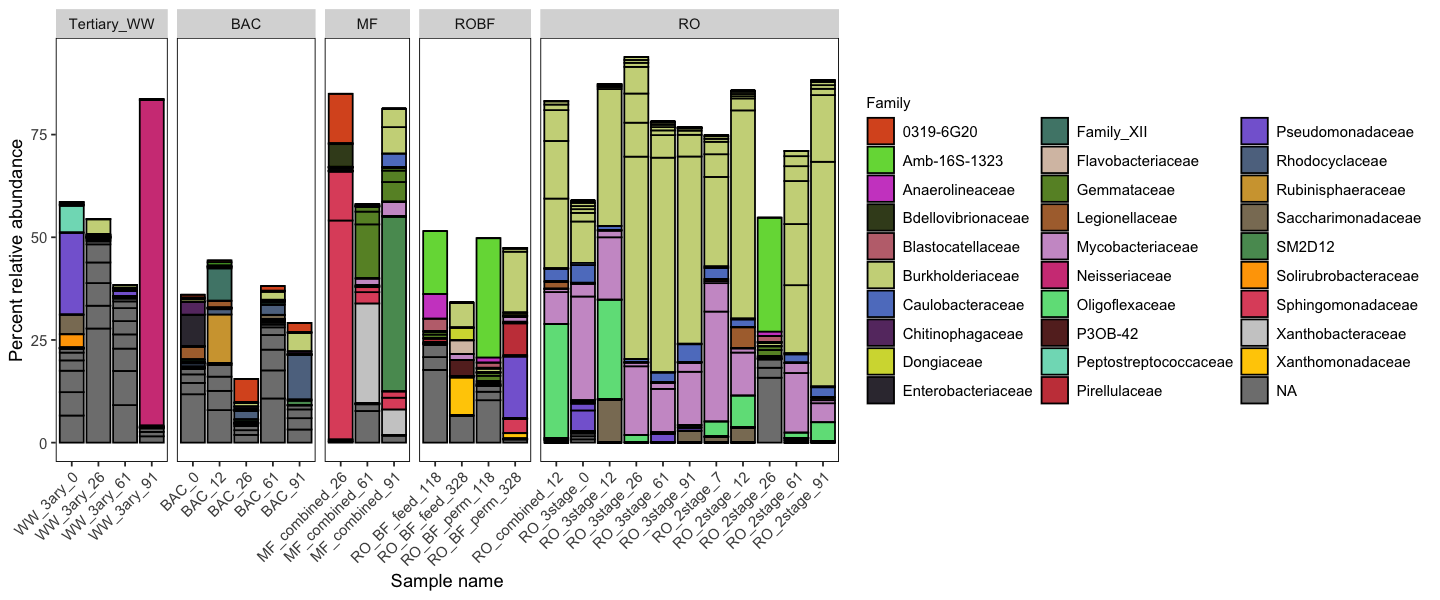

In [15]:
# Family barplot
options(repr.plot.width = 12, repr.plot.height = 5)

colors2 = colors[-1] 

plot_bar(ps_dpwf_perc_filt1.3, x="sample_name", fill="Family") + scale_fill_manual(values = colors2) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=3))
# ggsave("~/data/awtp2/amplicon_16S/figures/barplot_dpwf_bulk_perc_filt1.3_family_contam.png", device="png", width=12, height=5)
# ggsave("~/data/awtp2/amplicon_16S/figures/barplot_dpwf_bulk_perc_filt1.3_family_contam.svg", device="svg", width=12, height=5)

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1073102 
Run 1 stress 0.1104849 
Run 2 stress 0.1073102 
... New best solution
... Procrustes: rmse 4.599541e-06  max resid 1.140071e-05 
... Similar to previous best
Run 3 stress 0.1104849 
Run 4 stress 0.1085035 
Run 5 stress 0.1104849 
Run 6 stress 0.1104849 
Run 7 stress 0.1073102 
... Procrustes: rmse 1.647693e-05  max resid 5.687285e-05 
... Similar to previous best
Run 8 stress 0.1104849 
Run 9 stress 0.1104849 
Run 10 stress 0.1085035 
Run 11 stress 0.1073102 
... New best solution
... Procrustes: rmse 3.164164e-06  max resid 8.531416e-06 
... Similar to previous best
Run 12 stress 0.1104849 
Run 13 stress 0.1073102 
... Procrustes: rmse 2.318545e-06  max resid 6.994679e-06 
... Similar to previous best
Run 14 stress 0.1073102 
... Procrustes: rmse 2.458278e-06  max resid 6.384274e-06 
... Similar to previous best
Run 15 stress 0.1104851 
Run 16 stress 0.1073102 
... New best solution
... Procrustes: rms

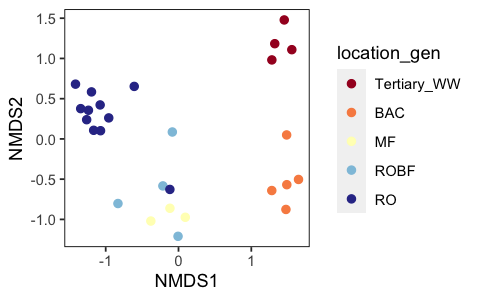

In [16]:
# Plot 
ps_dpwf_perc.ord <- ordinate(ps_dpwf_perc, "NMDS", "bray")
options(repr.plot.width = 4, repr.plot.height = 2.5)

plot_ordination(ps_dpwf_perc, ps_dpwf_perc.ord, color="location_gen") + 
    geom_point(size=2)+
    scale_color_manual(values=colorRampPalette(brewer.pal(11, "RdYlBu"))(5))+
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
# ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_NMDS_contam.png', device='png', width = 4, height = 2.5)
# ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_NMDS_contam.svg', device='svg', width = 4, height = 2.5)

# Normalize data and add combined taxonomy label

In [17]:
# Remove contaminated sample AWTP_2_RO2_bulk_4_B_Test_June2_W12 from dataset 
ps_awtp <- subset_samples(ps_awtp, subset = !(sample_code_full_and_batch %in% "AWTP_2_RO2_bulk_4_B_Test_June2_W12"))

# drop samples from 2nd RO membrane autopsy, conducted 7 months after the rest of the study 
# (the perm was so low biomass it was all contam from the feed)
ps_awtp <- subset_samples(ps_awtp, subset = !(sample_day == 328))

# note: within the decontam notebook, we created a "combined" taxa label:
# ranks <- c("Phylum", "Family", "Genus")
# combined_labels <- apply(tax_table(ps_raw)[ , ranks] , 1 , paste , sep = "", collapse = ">" )
# tax_table(ps_raw) <- cbind(tax_table(ps_raw), combined=combined_labels)

ranks <- c("Phylum", "Family")
combined_labels <- apply(tax_table(ps_awtp)[ , ranks] , 1 , paste , sep = "", collapse = ">" )
tax_table(ps_awtp) <- cbind(tax_table(ps_awtp), phyfam=combined_labels)

# subset and normalize to percents
ps_dpwf_perc <- transform_sample_counts(ps_awtp, function(x) 100*x/sum(x))
ps_dpwf_bulk <- subset_samples(ps_awtp, subset = !(location_gen %in% c('ROBF')))
ps_dpwf_bulk_perc <- transform_sample_counts(ps_dpwf_bulk, function(x) 100*x/sum(x))

In [18]:
ps_awtp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4002 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 4002 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 4002 reference sequences ]

In [19]:
# drop taxa that are now zero in all samples
ps_awtp_tax <- filter_taxa(ps_awtp, filterfun(kOverA(1, 0)), prune=FALSE)
ps_awtp <- prune_taxa(ps_awtp_tax, ps_awtp)

In [27]:
ps_awtp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3597 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 27 sample variables ]
tax_table()   Taxonomy Table:    [ 3597 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 3597 reference sequences ]

# Alpha diversity

Warning message in rarecurve(otu_tab, step = 100, col = sample_data(ps_awtp)$location_gen, :
“most observed count data have counts 1, but smallest count is 2”


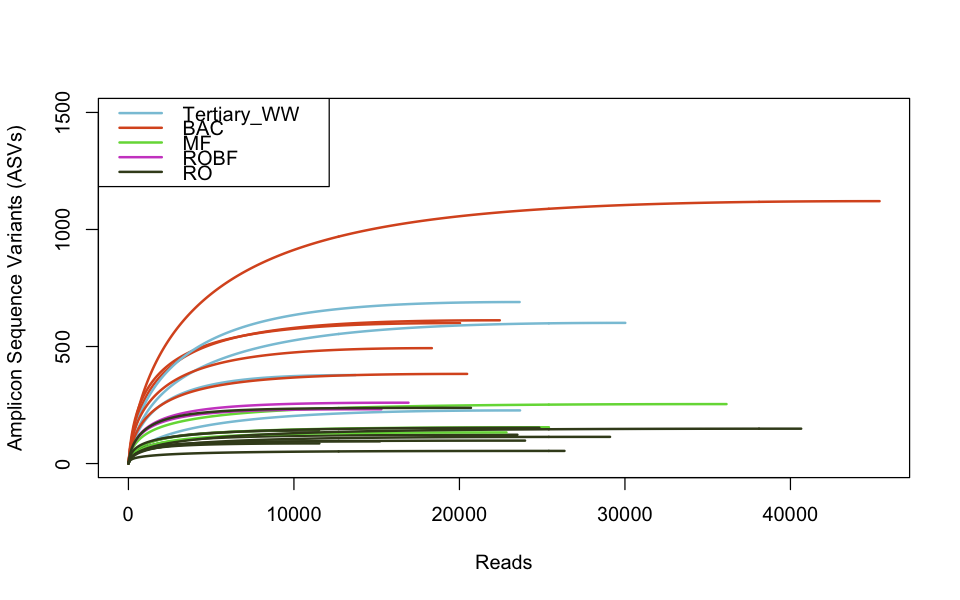

In [28]:
otu_tab <- as.data.frame(otu_table(ps_awtp))

locations_colors <- c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10], colors[11], colors[12])
palette(c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10], colors[11], colors[12]))
#locations_colors <- colorRampPalette(brewer.pal(11, "RdYlBu"))(8)
#palette(location_colors)

options(repr.plot.width = 8, repr.plot.height = 5)

#pdf("~/data/awtp2/amplicon_16S/figures/rarecurve_dpwf_nolabels.pdf", height=5, width=8)
rarecurve(otu_tab,
          step=100,
          col=sample_data(ps_awtp)$location_gen, 
          xlab="Reads",
          ylab="Amplicon Sequence Variants (ASVs)",
          lwd=2,
          ylim=c(0,1500),
          label=FALSE)

legend("topleft", 
       legend=c('Tertiary_WW','BAC','MF','ROBF','RO'), 
       col=locations_colors, 
       lty=1, lwd=2)
#dev.off()

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


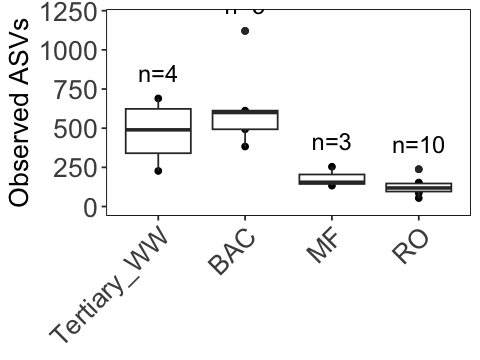

In [29]:
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}
options(repr.plot.width = 4, repr.plot.height = 3)

plot_richness(ps_dpwf_bulk, x="location_gen", measures=c("Observed"))+
    geom_boxplot()+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
     strip.background = element_blank(), 
     strip.text.x = element_blank(),
     axis.title.x = element_blank(),
     axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=16),
     axis.text.y = element_text(size=16),
     axis.title.y=element_text(size=16))+
    ylab("Observed ASVs") +
    ylim(0, 1200)+
    #scale_y_continuous(trans="log10", limits=c(1,1800), labels=trans_format("log10", math_format(10^.x)))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-1, size=5)+
    facet_grid(.~project_type, scale="free_x", space="free_x")

# ggsave("~/data/awtp2/amplicon_16S/figures/asv_observed_boxplot_dpwf_bulk.png", device="png", width=5, height=3)
# ggsave("~/data/awtp2/amplicon_16S/figures/asv_observed_boxplot_dpwf_bulk.pdf", device="pdf", width=8, height=3)

# Richness is a function of how much volume/how many cells we sampled... need to normalize for that somehow, including recovery efficiency

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


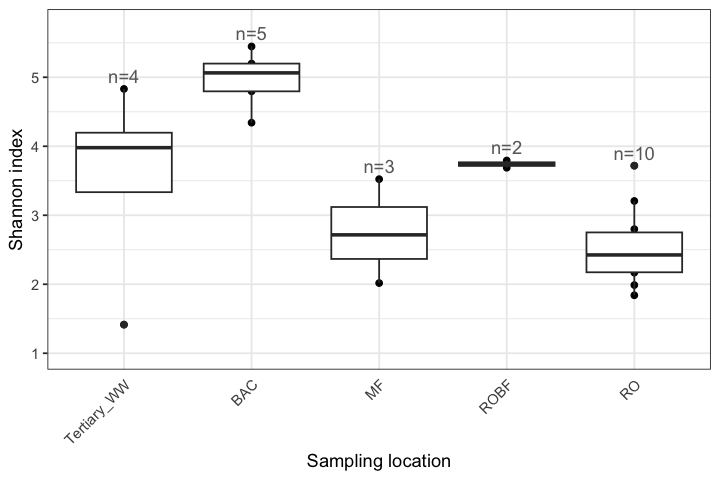

In [30]:
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}

options(repr.plot.width = 6, repr.plot.height = 4)
#locations_colors <- colorRampPalette(brewer.pal(11, "RdYlBu"))(8)
#palette(location_colors)
plot_adiv_sh <- plot_richness(ps_awtp, x="location_gen", measures=c("Shannon"))+
    geom_boxplot()+ #aes(fill=location_gen)
    ylab("Shannon index") +
    xlab("Sampling location")+
    ylim(1, 5.75)+
#     scale_fill_manual(values = colorRampPalette(brewer.pal(11, "RdYlBu"))(8),
#                       name="Location",labels=c("Tertiary wastewater","BAC","MF","RO biofilm feed",
#                                                                "RO biofilm permeate","RO"))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-0.5,colour = "#696969")+
    theme_bw()+
    theme(axis.text.x=element_text(angle=45, hjust=1),
    axis.ticks.x=element_blank(),
    strip.text.x = element_blank())
plot_adiv_sh

# ggsave("~/data/awtp2/amplicon_16S/figures/alpha_div_shannon_dpwf_bulk_bw.png", device="png", height=3, width=5)

In [31]:
sample_data(ps_awtp) <- sample_data(ps_awtp) %>% add_column(shannon = NA)
sample_data(ps_awtp)$shannon <- estimate_richness(ps_awtp,  split= TRUE, measure= "Shannon")

pairwise.wilcox.test(as.matrix(sample_data(ps_awtp)$shannon), as.matrix(sample_data(ps_awtp)$location_gen),
                 p.adjust.method = "hochberg")

Warning message in estimate_richness(ps_awtp, split = TRUE, measure = "Shannon"):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”



	Pairwise comparisons using Wilcoxon rank sum exact test 

data:  as.matrix(sample_data(ps_awtp)$shannon) and as.matrix(sample_data(ps_awtp)$location_gen) 

            BAC    MF     RO     ROBF  
MF          0.3214 -      -      -     
RO          0.0067 0.6923 -      -     
ROBF        0.5714 0.6923 0.4444 -     
Tertiary_WW 0.4444 0.6923 0.6923 0.6923

P value adjustment method: hochberg 

In [32]:
# export as csv to plot with FCM data
sample_data_shannon <- as.data.frame(as.matrix(sample_data(ps_awtp)))
sample_data_shannon <- sample_data_shannon %>% select('location_code', 'sample_day', 'shannon')
#write.table(sample_data_shannon, '~/data/awtp2/amplicon_16S/asv_shannon.tsv', sep='\t', quote=FALSE)

# Taxonomic composition

In [33]:
ps_dpwf_perc_filt1.3 <- filter_taxa(ps_dpwf_perc, filterfun(kOverA(1, 3)), TRUE)
ps_dpwf_perc_filt1.3
ps_dpwf_perc_filt2.1 <- filter_taxa(ps_dpwf_perc, filterfun(kOverA(2, 1)), TRUE)
ps_dpwf_perc_filt2.1
ps_dpwf_perc_filt1.1 <- filter_taxa(ps_dpwf_perc, filterfun(kOverA(1, 1)), TRUE)
ps_dpwf_perc_filt1.1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 66 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 66 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 66 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 69 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 69 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 69 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 170 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 170 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 170 reference sequences ]

## Barplots

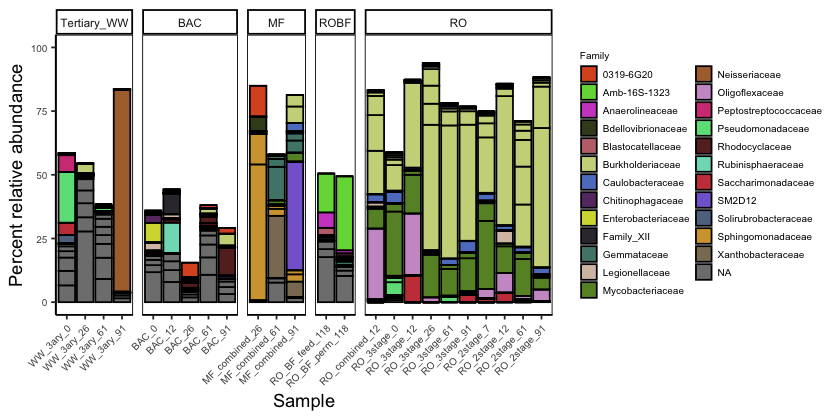

In [34]:
# Family
options(repr.plot.width = 7, repr.plot.height = 3.5)

colors2 = colors[-1] 

plot_bar(ps_dpwf_perc_filt1.3, x="sample_name", fill="Family") + scale_fill_manual(values = colors2) + 
    ylim(0,100)+
    theme_classic()+
    theme(panel.background=element_blank(), 
          panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=6),
          axis.text.y = element_text(size=6),
          strip.text = element_text(size=7),
          legend.text=element_text(size=6), 
          legend.title=element_text(size=6),
          legend.key.size = unit(0.15, 'in'),
          legend.position="right")+
    facet_grid(.~location_gen, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample")+
guides(fill=guide_legend(ncol=2))
# ggsave("~/data/awtp2/amplicon_16S/figures/barplot_dpwf_bulk_perc_filt1.3_family.png", device="png", width=7, height=3.5)
# ggsave("~/data/awtp2/amplicon_16S/figures/barplot_dpwf_bulk_perc_filt1.3_family.pdf", device="pdf", width=7, height=3.5)
# ggsave("~/data/awtp2/amplicon_16S/figures/barplot_dpwf_bulk_perc_filt1.3_family.svg", device="svg", width=7, height=3.5)

In [111]:
# trying different color palette
colors_phy <- distinctColorPalette(15, runTsne=TRUE) #altCol=TRUE,

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 15 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 15 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 15 reference sequences ]

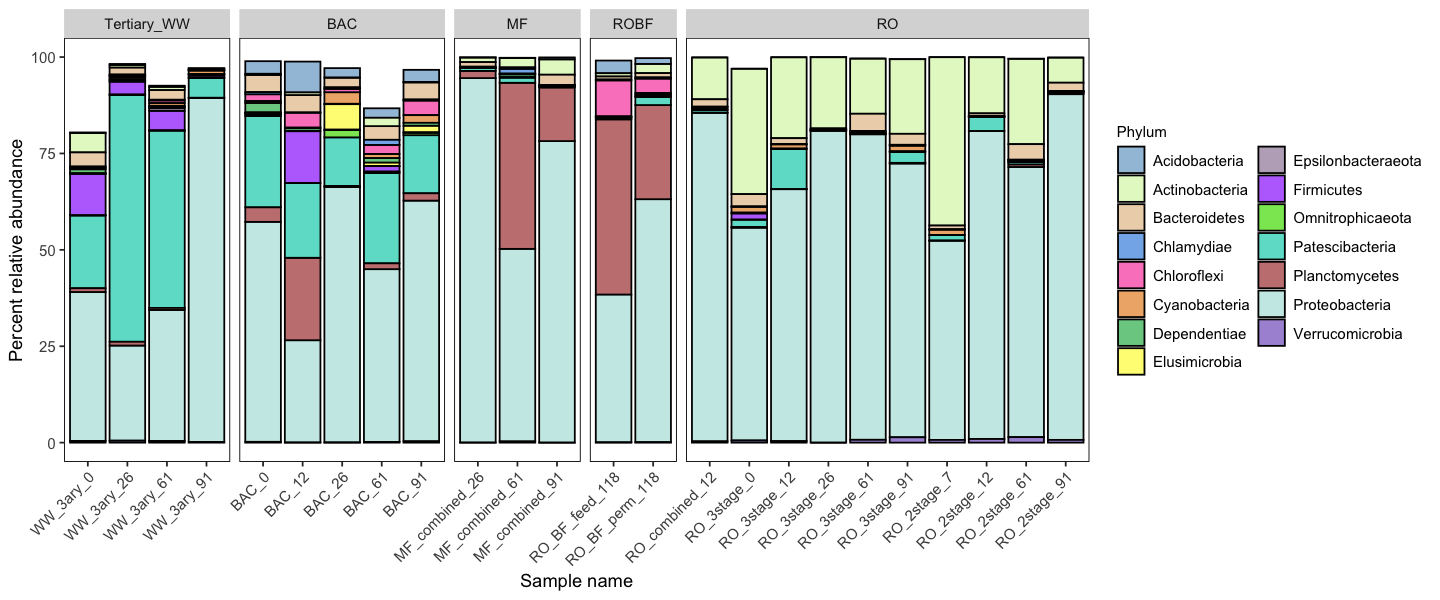

In [113]:
## Phyla agglomerated barplot

ps_dpwf_perc_phylum <- tax_glom(ps_dpwf_perc, "Phylum")
ps_dpwf_perc_phylum_filt1.05 <- filter_taxa(ps_dpwf_perc_phylum, filterfun(kOverA(1, 0.5)), TRUE)
ps_dpwf_perc_phylum_filt1.05

## Plot bar and heatmap
options(repr.plot.width = 12, repr.plot.height = 5)

plot_bar(ps_dpwf_perc_phylum_filt1.05, x="sample_name", fill="Phylum") + scale_fill_manual(values = colors_phy) + #colors
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))
# ggsave("~/data/awtp2/amplicon_16S/figures/barplot_dpwf_perc_filt1_over0.5_phylum.png", device="png", width=12, height=5)

## Heatmaps

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”


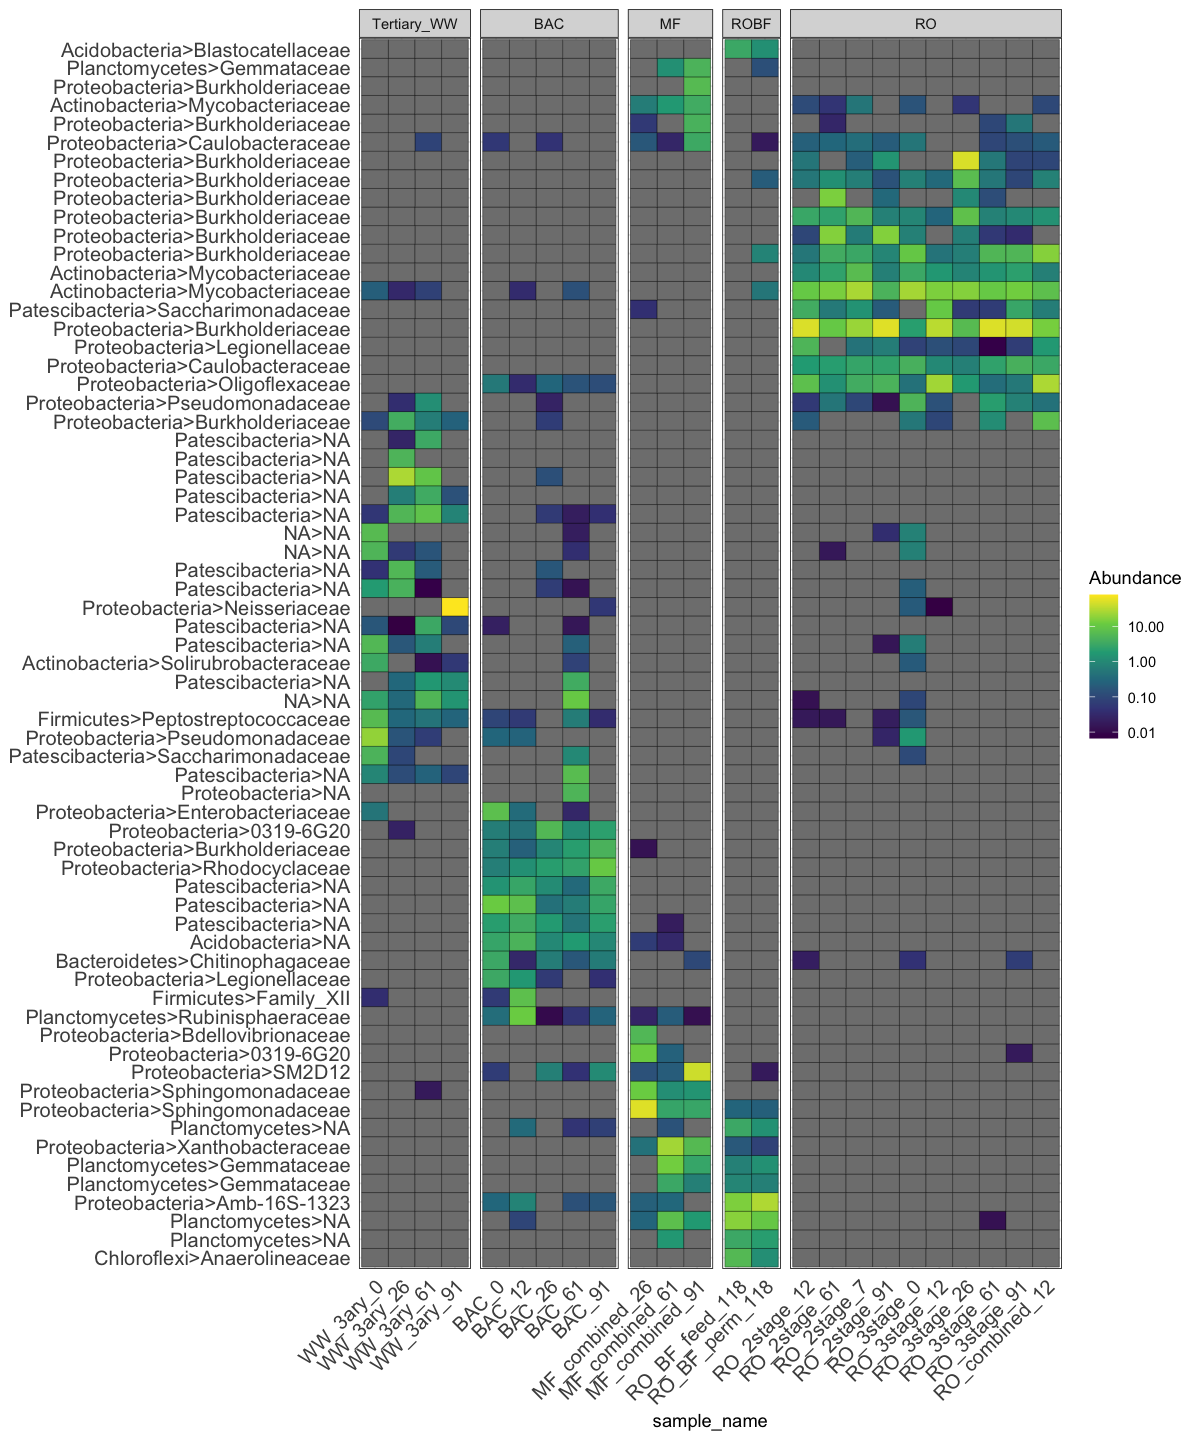

In [119]:
#plot heatmap: all taxa in at least 1 sample at >3% relative abund (ps_dpwf_perc_filt1.3)
options(repr.plot.width = 10, repr.plot.height = 12)
plot_heatmap(ps_dpwf_perc_filt1.3, taxa.label = "phyfam", sample.label = "sample_name", sample.order = "sample_name", method="NMDS")+
    scale_fill_continuous(type='viridis', trans = log_trans(10))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")+
    geom_tile(color="black")+
    theme_bw()+
    theme(axis.text.y = element_text(size=12), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12))
# ggsave("~/data/awtp2/amplicon_16S/figures/heatmap_dpwf_perc_filt1.3.png", device="png", width=12, height=12)

## Examining RO membrane samples (and MF and RO perm)

In [29]:
# # plotting just single locations to see more depth
# ps_ROmem <- subset_samples(ps_dpwf_perc, subset = location_gen %in% c("MF", "RO", "Feed","Perm"))
# ps_ROmem_filt <- filter_taxa(ps_ROmem, filterfun(kOverA(1, 2.5)), TRUE)
# ps_ROmem_filt

# #plot heatmap
# options(repr.plot.width = 12, repr.plot.height = 10)
# plot_heatmap(ps_ROmem_filt, taxa.label = "phyfam", sample.label = "sample_name", sample.order = "sample_date", method="NMDS")+
#             scale_fill_continuous(type='viridis', trans = log_trans(10))+
#      theme(axis.text.y = element_text(size=12), 
#            axis.title.y = element_blank(), 
#            axis.ticks = element_blank(),
#            axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12))+
#      facet_grid(.~location_gen, scale="free_x", space="free_x")
# #ggsave("~/data/awtp2/amplicon_16S/figures/heatmap_MFRO.png", device="png", width=8, height=8)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”


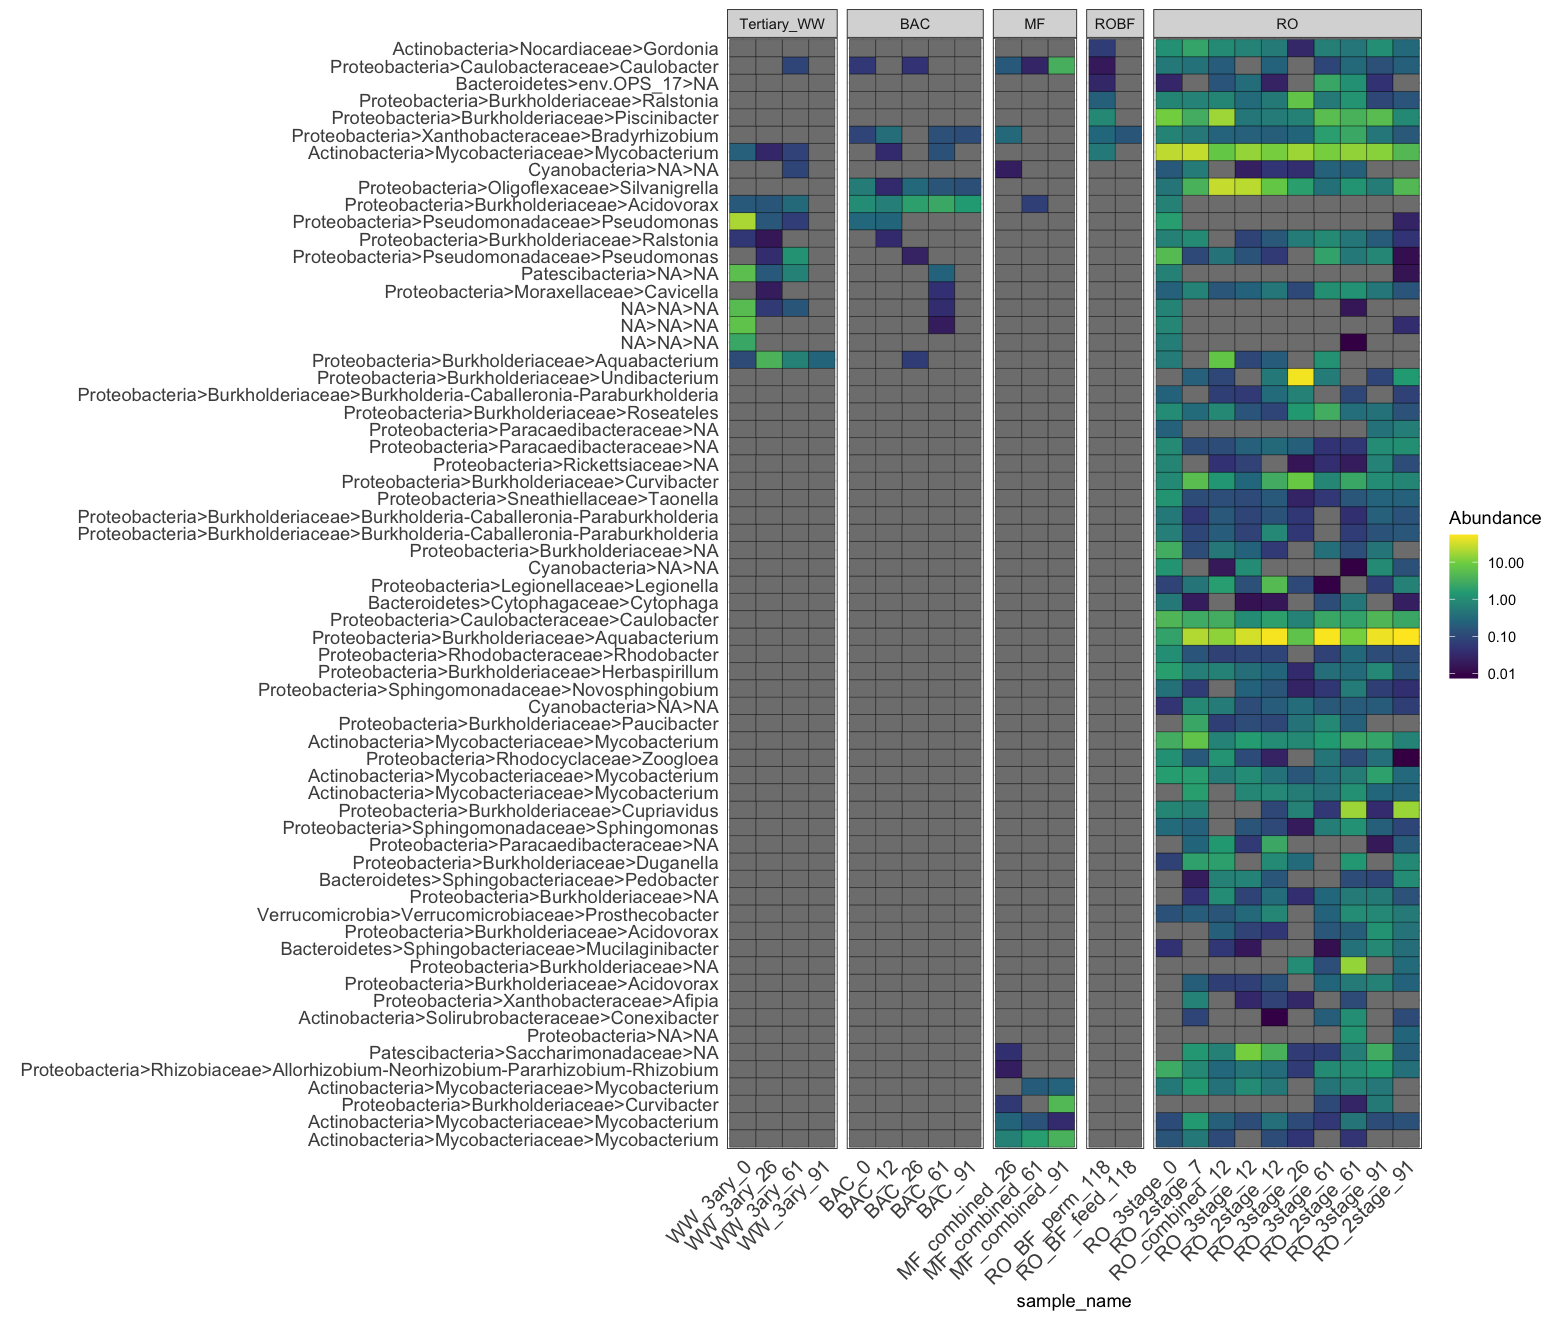

In [121]:
# plotting just single locations to see more depth
ps_ROmem <- subset_samples(ps_dpwf_perc, subset = location_gen %in% c("RO"))
ps_ROmem_tax <- filter_taxa(ps_ROmem, filterfun(kOverA(1, 0.5)), prune=FALSE)
ps_ROmem_filt <- prune_taxa(ps_ROmem_tax, ps_dpwf_perc)

#plot heatmap
options(repr.plot.width = 13, repr.plot.height = 11)
plot_heatmap(ps_ROmem_filt, taxa.label = "combined", sample.label = "sample_name", sample.order = "sample_date", method="NMDS")+
    scale_fill_continuous(type='viridis', trans = log_trans(10))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")+
    geom_tile(color="black")+
    theme_bw()+
    theme(axis.text.y = element_text(size=11), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12))
     
# ggsave("~/data/awtp2/amplicon_16S/figures/heatmap_RO_perc_filt1_over0.5.png", device="png", width=13, height=11)

In [122]:
# what % of the reads are accounted for by the top 2 ASVs

# extract the otu matrix as a dataframe, transpose, remove ASVs that are zero in all samples
ro.mem.df <- as.data.frame(otu_table(ps_ROmem))
ro.mem.df <- as.data.frame(t(ro.mem.df))
ro.mem.df <- filter_all(ro.mem.df, any_vars(. != 0))

# new column with avg relative abundance of each ASV across all RO bulk samples
ro.mem.df["avg_perc_abund"] <- rowMeans(ro.mem.df)

# get taxonomy for these
ro.mem.tax <- as.data.frame(tax_table(ps_ROmem))
ro.mem.df <- merge(ro.mem.df, ro.mem.tax, all.x=TRUE, by=0)

# sort in descending order of abundance
ro.mem.df <- arrange(ro.mem.df, desc(avg_perc_abund))

# top 2 ASVs are Aquabacterium and Mycobacterium
head(ro.mem.df[c("avg_perc_abund", "combined")])

,avg_perc_abund,combined
,<dbl>,<chr>
1,29.137016,Proteobacteria>Burkholderiaceae>Aquabacterium
2,14.483679,Actinobacteria>Mycobacteriaceae>Mycobacterium
3,7.250616,Proteobacteria>Oligoflexaceae>Silvanigrella
4,5.229453,Proteobacteria>Burkholderiaceae>Undibacterium
5,4.705213,Proteobacteria>Burkholderiaceae>Piscinibacter
6,3.507188,Proteobacteria>Burkholderiaceae>Cupriavidus


# Beta diversity

## PCoA and NMDS

In [37]:
ps_dpwf_rare <- rarefy_even_depth(ps_awtp)
ps_dpwf_clr <- microbiome::transform(ps_awtp, transform='clr')

ps_dpwf_rare.nmds <- ordinate(ps_dpwf_rare, "NMDS", "bray")
ps_dpwf_perc.nmds <- ordinate(ps_dpwf_perc, "NMDS", "bray")
ps_dpwf_clr.nmds <- ordinate(ps_dpwf_perc, "NMDS", "euclidean")

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

344OTUs were removed because they are no longer 
present in any sample after random subsampling


...



Square root transformation
Wisconsin double standardization
Run 0 stress 0.1537264 
Run 1 stress 0.1796629 
Run 2 stress 0.07688731 
... New best solution
... Procrustes: rmse 0.1430089  max resid 0.2764779 
Run 3 stress 0.0769087 
... Procrustes: rmse 0.005662016  max resid 0.02045479 
Run 4 stress 0.0769087 
... Procrustes: rmse 0.005659433  max resid 0.02048059 
Run 5 stress 0.07690871 
... Procrustes: rmse 0.005664161  max resid 0.02042562 
Run 6 stress 0.07688731 
... Procrustes: rmse 9.063455e-06  max resid 3.164549e-05 
... Similar to previous best
Run 7 stress 0.1726495 
Run 8 stress 0.07688731 
... Procrustes: rmse 8.937796e-06  max resid 3.149471e-05 
... Similar to previous best
Run 9 stress 0.07688731 
... Procrustes: rmse 6.433198e-06  max resid 2.046996e-05 
... Similar to previous best
Run 10 stress 0.0769087 
... Procrustes: rmse 0.005661648  max resid 0.02045793 
Run 11 stress 0.07690874 
... Procrustes: rmse 0.005652456  max resid 0.02053887 
Run 12 stress 0.07688732 

In [38]:
ps_dpwf_rare.nmds


Call:
metaMDS(comm = veganifyOTU(physeq), distance = distance) 

global Multidimensional Scaling using monoMDS

Data:     wisconsin(sqrt(veganifyOTU(physeq))) 
Distance: bray 

Dimensions: 2 
Stress:     0.07688731 
Stress type 1, weak ties
Best solution was repeated 7 times in 20 tries
The best solution was from try 2 (random start)
Scaling: centring, PC rotation, halfchange scaling 
Species: expanded scores based on ‘wisconsin(sqrt(veganifyOTU(physeq)))’ 


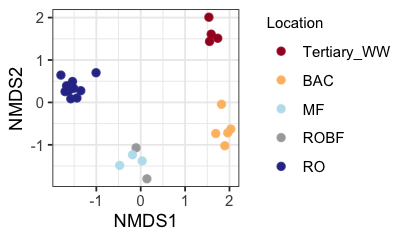

In [39]:
# Plot NMDS with rarefaction as the normalization method
options(repr.plot.width = 3.4, repr.plot.height = 2)

location_colors=c('#A50026','#FDBE70','#BCE1EE',"dark gray",'#313695')

plot_ordination(ps_awtp, ps_dpwf_rare.nmds, color="location_gen") + 
    geom_point(size=2, alpha=0.75)+
    scale_color_manual(values=location_colors)+ #colorRampPalette(brewer.pal(11, "RdYlBu"))(8)
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))+
    theme_bw()+
        guides(color = guide_legend(title = "Location"))+
    theme(axis.text.x = element_text(size=9),
      axis.text.y = element_text(size=9),
      legend.text=element_text(size=9), 
      legend.title=element_text(size=9))
# ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_rare_NMDS.svg', device='svg', width = 3.4, height = 2)
# ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_rare_NMDS.png', device='png', width = 3.4, height = 2)
# ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_rare_NMDS.pdf', device='pdf', width = 3.4, height = 2)

In [40]:
ps_dpwf_perc.nmds


Call:
metaMDS(comm = veganifyOTU(physeq), distance = distance) 

global Multidimensional Scaling using monoMDS

Data:     wisconsin(sqrt(veganifyOTU(physeq))) 
Distance: bray 

Dimensions: 2 
Stress:     0.0744281 
Stress type 1, weak ties
Best solution was repeated 14 times in 20 tries
The best solution was from try 2 (random start)
Scaling: centring, PC rotation, halfchange scaling 
Species: expanded scores based on ‘wisconsin(sqrt(veganifyOTU(physeq)))’ 


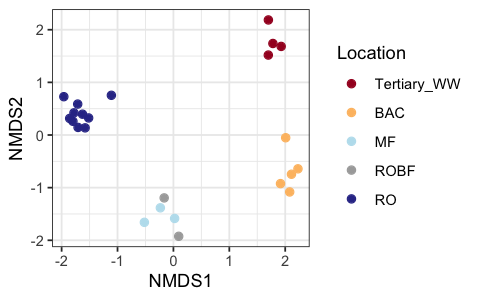

In [41]:
# Plot NMDS with percent normalization
options(repr.plot.width = 4, repr.plot.height = 2.5)

location_colors=c('#A50026','#FDBE70','#BCE1EE',"dark gray",'#313695')

plot_ordination(ps_dpwf_perc, ps_dpwf_perc.nmds, color="location_gen") + 
    geom_point(size=2, pch=21)+
    scale_color_manual(values=location_colors)+ #colorRampPalette(brewer.pal(11, "RdYlBu"))(8)
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))+
    theme_bw()+
    guides(color = guide_legend(title = "Location"))
#ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_perc_NMDS.pdf', device='pdf', width = 4, height = 2.5)
# ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_perc_NMDS.png', device='png', width = 4, height = 2.5)

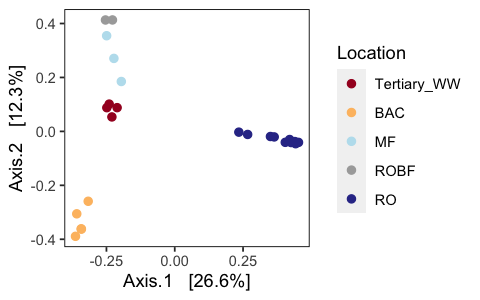

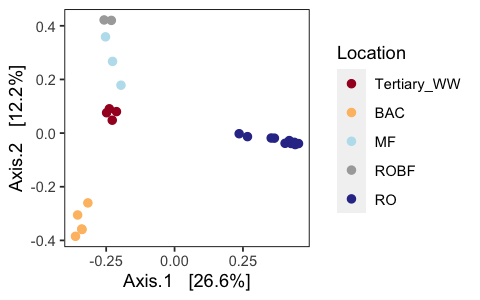

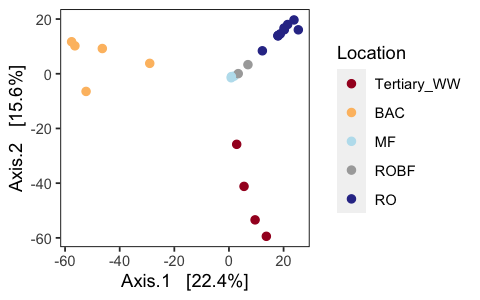

In [42]:
# Ordinate with PCoA on bray-curtis dissimilarity (percent normalized)
options(repr.plot.width = 4, repr.plot.height = 2.5)

ps_dpwf_perc.pcoa <- ordinate(ps_dpwf_perc, "PCoA", "bray")

plot_ordination(ps_dpwf_perc, ps_dpwf_perc.pcoa, color="location_gen") + 
    geom_point(size=2)+
    scale_color_manual(values = location_colors,
                       name="Location")+ #labels=c("WW_3ary", "BAC", "MF", "RO mem. retentate side", "RO mem. permeate side", "RO")
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_perc_PCoA.png', device='png', width = 4, height = 2.5)


# Ordinate with PCoA on bray-curtis dissimilarity (rarefied)

ps_dpwf_rare.pcoa <- ordinate(ps_dpwf_rare, "PCoA", "bray")

plot_ordination(ps_dpwf_rare, ps_dpwf_rare.pcoa, color="location_gen") + 
    geom_point(size=2)+
    scale_color_manual(values = location_colors,
                       name="Location")+ #labels=c("WW_3ary", "BAC", "MF", "RO mem. retentate side", "RO mem. permeate side", "RO")
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_rare_PCoA.png', device='png', width = 4, height = 2.5)


# Ordinate with PCoA on Aichison (clr transformed data with euclidean distance)

ps_dpwf_clr.pcoa <- ordinate(ps_dpwf_clr, "PCoA", "euclidean")

plot_ordination(ps_dpwf_clr, ps_dpwf_clr.pcoa, color="location_gen") + 
    geom_point(size=2)+
    scale_color_manual(values = location_colors,
                       name="Location")+ #labels=c("WW_3ary", "BAC", "MF", "RO mem. retentate side", "RO mem. permeate side", "RO")
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
# ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_aichison_PCoA.png', device='png', width = 4, height = 2.5)

## PERMANOVA with 3 different data normalizations on bulk water only

In [43]:
#Normalized by percent (changed the order of formula and result is similar)
sample_info = as((sample_data(ps_dpwf_bulk_perc)), "data.frame")
bulk_bray_perc = phyloseq::distance(ps_dpwf_bulk_perc, "bray")
bulk_adonis = adonis2(bulk_bray_perc ~ sample_day + location_gen, sample_info)
bulk_adonis

#rarefied
sample_info = as((sample_data(ps_dpwf_bulk)), "data.frame")
ps_dpwf_bulk_rare <- rarefy_even_depth(ps_dpwf_bulk)
bray_rare = phyloseq::distance(ps_dpwf_bulk_rare, "bray")
adonis_rare = adonis2(bray_rare ~ location_gen + sample_date, sample_info)
adonis_rare

##CLR-transformed Euclidean distance (Aitchison distance) 
##Suggested in Gloor et al 2017: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5695134/
ps_bulk_clr <- microbiome::transform(ps_dpwf_bulk, transform='clr')
sample_info = as(sample_data(ps_bulk_clr), "data.frame")
bulk_eucl = phyloseq::distance(ps_bulk_clr, "euclidean")
bulk_adonis_clr = adonis2(bulk_eucl ~ location_gen + sample_date, sample_info)
bulk_adonis_clr

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sample_day,1,0.3545853,0.04104199,1.514318,0.096
location_gen,3,4.3043506,0.49821334,6.127491,0.001
Residual,17,3.9806373,0.46074467,NA,NA
Total,21,8.6395731,1.00000000,NA,NA


You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

940OTUs were removed because they are no longer 
present in any sample after random subsampling


...



,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
location_gen,3,4.3160943,0.49925580,6.101242,0.001
sample_date,1,0.3202911,0.03704904,1.358293,0.149
Residual,17,4.0086705,0.46369515,NA,NA
Total,21,8.6450559,1.00000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
location_gen,3,32874.667,0.49543909,5.957471,0.001
sample_date,1,2209.996,0.03330584,1.201471,0.254
Residual,17,31269.946,0.47125507,NA,NA
Total,21,66354.609,1.00000000,NA,NA


## Check for heterogeneity of beta-dispersions

In [44]:
beta <- betadisper(bulk_eucl, sample_info$location_gen)
permutest(beta, permutations = 10000)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 10000

Response: Distances
          Df Sum Sq Mean Sq      F N.Perm    Pr(>F)    
Groups     3 3501.8 1167.26 28.674  10000 9.999e-05 ***
Residuals 18  732.7   40.71                            
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

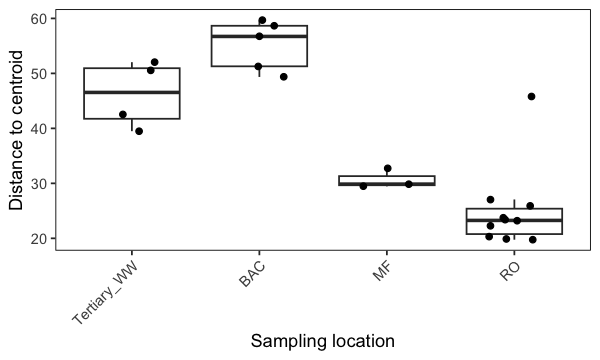

In [49]:
betadisper_distances <- as.data.frame(beta$distances)
colnames(betadisper_distances) <- c('distance_to_centroid')
betadisper_distances <- merge(betadisper_distances, sample_info, by = 0)

options(repr.plot.width = 5, repr.plot.height = 3) #for plotting size in jupyter
ggplot(betadisper_distances, aes(x=location_gen, y=distance_to_centroid))+
    geom_boxplot(outlier.shape = NA)+
    geom_jitter(position=position_jitter(0.2))+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    ylab('Distance to centroid')+
    xlab('Sampling location')
# ggsave("~/data/awtp2/amplicon_16S/figures/beta_dispersion.pdf", device="pdf", width=5, height=3)
ggsave("~/data/awtp2/amplicon_16S/figures/beta_dispersion.png", device="png", width=5, height=3)

# Shared ASVs across treatment processes

In [130]:
#function to identify core community within a location 
get_core_seqs <- function(ps_name, min_abund, min_samples, location){
    location_ids = as.character(get_variable(ps_name, "location_gen")) == location
    ps_sub <- prune_samples(location_ids, ps_name) #subsample by location
    
    #where number of samples=min_samples, for counts input min_reads-1 (because KOverA uses > not >=)
    core <- filter_taxa(ps_sub, filterfun(kOverA(min_samples, min_abund)), prune=TRUE) 
    return(row.names(tax_table(core))) #core sequences
}

In [131]:
sample_data(ps_dpwf_bulk_perc)$location_gen

[1] MF          BAC         BAC         Tertiary_WW Tertiary_WW Tertiary_WW
 [7] Tertiary_WW BAC         RO          RO          RO          RO         
[13] MF          MF          BAC         BAC         RO          RO         
[19] RO          RO          RO          RO         
Levels: Tertiary_WW BAC MF RO

In [132]:
# Set parameters
min_abund <- 0.05 #A percentage or reads -- depends on dataset (rel. or absolute abundances)
min_samples <- 2 #k
dataset <- ps_dpwf_bulk_perc

# Select core community of all different treatment steps
core.WW3 <- get_core_seqs(dataset, min_abund, min_samples, "Tertiary_WW") 
core.BAC <- get_core_seqs(dataset, min_abund, min_samples, "BAC")
core.MF <- get_core_seqs(dataset, min_abund, min_samples, "MF") 
core.RO <- get_core_seqs(dataset, min_abund, min_samples, "RO")

In [133]:
colorRampPalette(brewer.pal(11, "RdYlBu"))(4)

[1] "#A50026" "#FDBE70" "#BCE1EE" "#313695"

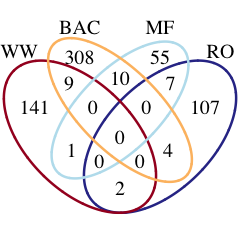

In [134]:
options(repr.plot.width = 2, repr.plot.height = 2)
#pdf("~/data/awtp2/amplicon_16S/figures/venn_diagram_0.05perc_2sampmin.pdf", width=2, height=2)
cores=list(
    "WW"=core.WW3,
    "RO"=core.RO,
    "BAC"=core.BAC,
    "MF"=core.MF    
    )
grid.draw(venn.diagram(cores, NULL, col=c('#A50026','#313695','#FDBE70','#BCE1EE'), 
                       fill=c("white", "white", "white", "white"))) #fill=c("white", "white", "white", "white")
#dev.off()

In [157]:
# what are the 2 overlapping between WW3 and RO
asvs_ww3_ro <- intersect(core.WW3,core.RO)
tax_df <- as.data.frame(tax_table(ps_dpwf_bulk_perc)) ## %>% filter(rownames %in% asvs_ww3_ro)
tax_df[rownames(tax_df) %in% asvs_ww3_ro,]

,Kingdom,Phylum,Class,Order,Family,Genus,combined,phyfam
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ASV22,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium,Actinobacteria>Mycobacteriaceae>Mycobacterium,Actinobacteria>Mycobacteriaceae
ASV110,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Aquabacterium,Proteobacteria>Burkholderiaceae>Aquabacterium,Proteobacteria>Burkholderiaceae


In [135]:
#plot cores
ps_core <- prune_taxa(unique(c(core.WW3,core.RO,core.BAC, core.MF)), dataset)
ps_core_filt1.05 <- filter_taxa(ps_core, filterfun(kOverA(1, 0.05)), TRUE)
ps_core_filt1.05

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 644 taxa and 22 samples ]
sample_data() Sample Data:       [ 22 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 644 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 644 reference sequences ]

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in discrete y-axis”


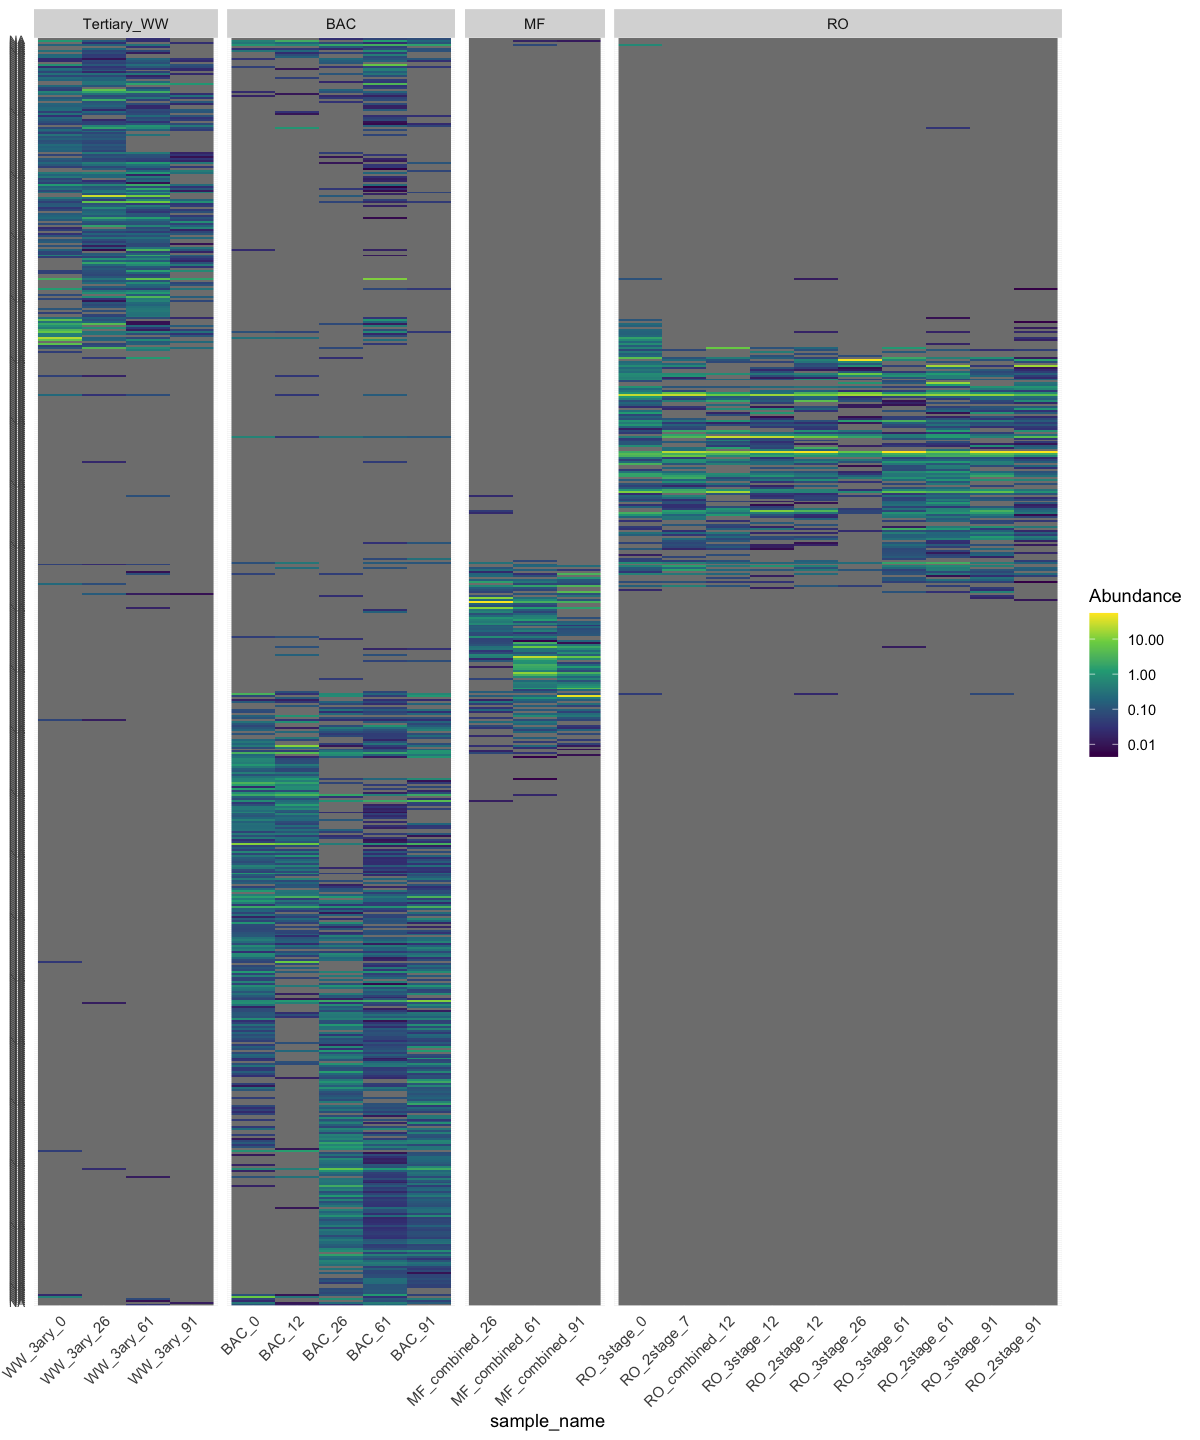

In [136]:
#plot heatmap
options(repr.plot.width = 10, repr.plot.height = 12)
plot_heatmap(ps_core_filt1.05, taxa.label = "phyfam", sample.label = "sample_name", sample.order = "sample_date", method="NMDS")+
            scale_fill_continuous(type='viridis', trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_gen, scale="free_x", space="free_x")
#ggsave('~/data/awtp2/amplicon_16S/heatmap_cores_filt1.05.png', device='png', width=12, height=9)

In [143]:
#plot all intersections
partitions <- get.venn.partitions(cores)
allover_seqs <- partitions[partitions$RO==TRUE & partitions$WW3==TRUE & partitions$MF==FALSE & partitions$BAC==FALSE]$..values..
allover_seqs

NULL

In [141]:
partitions

,WW,RO,BAC,MF,..set..,..values..,..count..
,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<named list>,<int>
1,TRUE,TRUE,TRUE,TRUE,WW∩RO∩BAC∩MF,,0
2,FALSE,TRUE,TRUE,TRUE,(RO∩BAC∩MF)∖(WW),,0
3,TRUE,FALSE,TRUE,TRUE,(WW∩BAC∩MF)∖(RO),,0
4,FALSE,FALSE,TRUE,TRUE,(BAC∩MF)∖(WW∪RO),"ASV38, A....",10
5,TRUE,TRUE,FALSE,TRUE,(WW∩RO∩MF)∖(BAC),,0
6,FALSE,TRUE,FALSE,TRUE,(RO∩MF)∖(WW∪BAC),"ASV2, AS....",7
7,TRUE,FALSE,FALSE,TRUE,(WW∩MF)∖(RO∪BAC),ASV32,1
8,FALSE,FALSE,FALSE,TRUE,(MF)∖(WW∪RO∪BAC),"ASV40, A....",55
9,TRUE,TRUE,TRUE,FALSE,(WW∩RO∩BAC)∖(MF),,0


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in discrete y-axis”


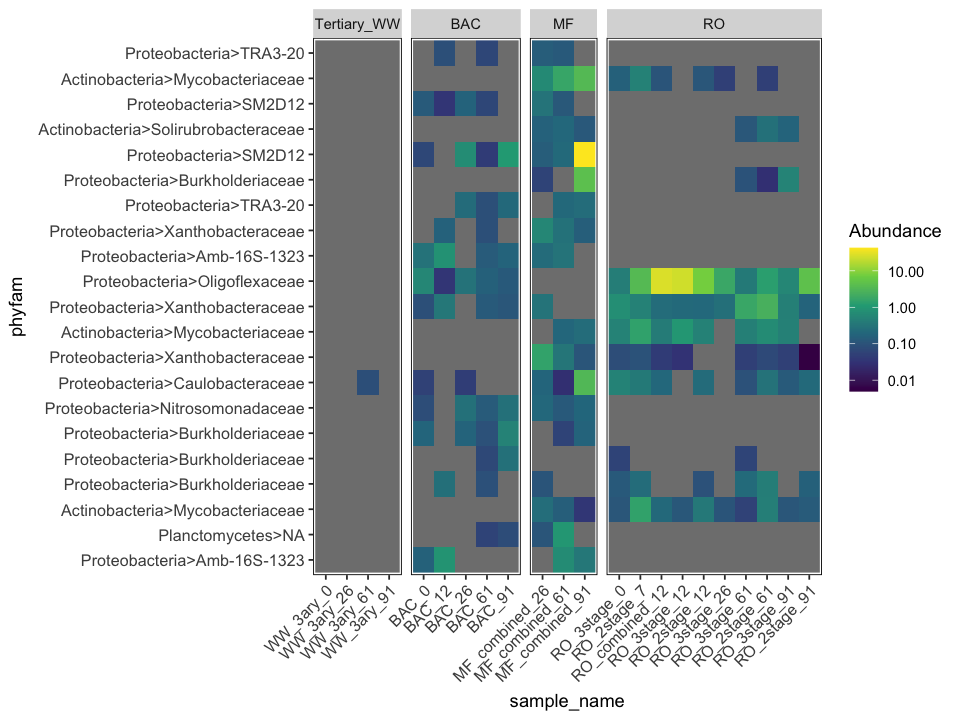

In [137]:
#plot all intersections
partitions <- get.venn.partitions(cores)
allover_seqs <- partitions[partitions$BAC==TRUE & partitions$WW3==TRUE,]$..values..
allover_seqs <- append(allover_seqs, partitions[partitions$BAC==TRUE & partitions$MF==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$BAC==TRUE & partitions$RO==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$RO==TRUE & partitions$MF==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$RO==TRUE & partitions$WW3==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$MF==TRUE & partitions$WW3==TRUE,]$..values..)

allover_seqs <- unname(c(unlist(allover_seqs))) #convert to unnamed vector
ps_allover <- prune_taxa(allover_seqs, dataset)

options(repr.plot.width = 8, repr.plot.height = 6)
plot_heatmap(ps_allover, taxa.label = "phyfam", sample.label = "sample_name", sample.order = "sample_date", method=NULL)+
            scale_fill_continuous(type='viridis', trans = log_trans(10))+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in discrete y-axis”


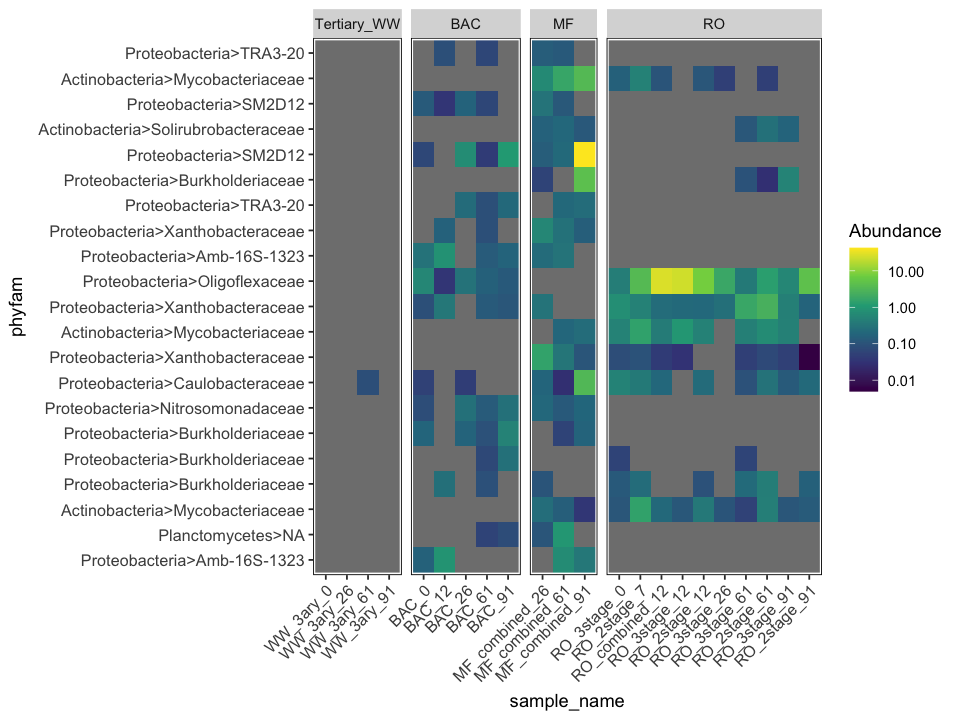

In [117]:
#plot all intersections
partitions <- get.venn.partitions(cores)
allover_seqs <- partitions[partitions$BAC==TRUE & partitions$WW3==TRUE,]$..values..
allover_seqs <- append(allover_seqs, partitions[partitions$BAC==TRUE & partitions$MF==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$BAC==TRUE & partitions$RO==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$RO==TRUE & partitions$MF==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$RO==TRUE & partitions$WW3==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$MF==TRUE & partitions$WW3==TRUE,]$..values..)

allover_seqs <- unname(c(unlist(allover_seqs))) #convert to unnamed vector
ps_allover <- prune_taxa(allover_seqs, dataset)

# options(repr.plot.width = 6, repr.plot.height = 4)
# plot_bar(ps_allover, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors) + 
#     theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
#           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
#     facet_grid(.~location_gen, scale="free_x", space="free_x")

options(repr.plot.width = 8, repr.plot.height = 6)
plot_heatmap(ps_allover, taxa.label = "phyfam", sample.label = "sample_name", sample.order = "sample_date", method=NULL)+
            scale_fill_continuous(type='viridis', trans = log_trans(10))+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in discrete y-axis”


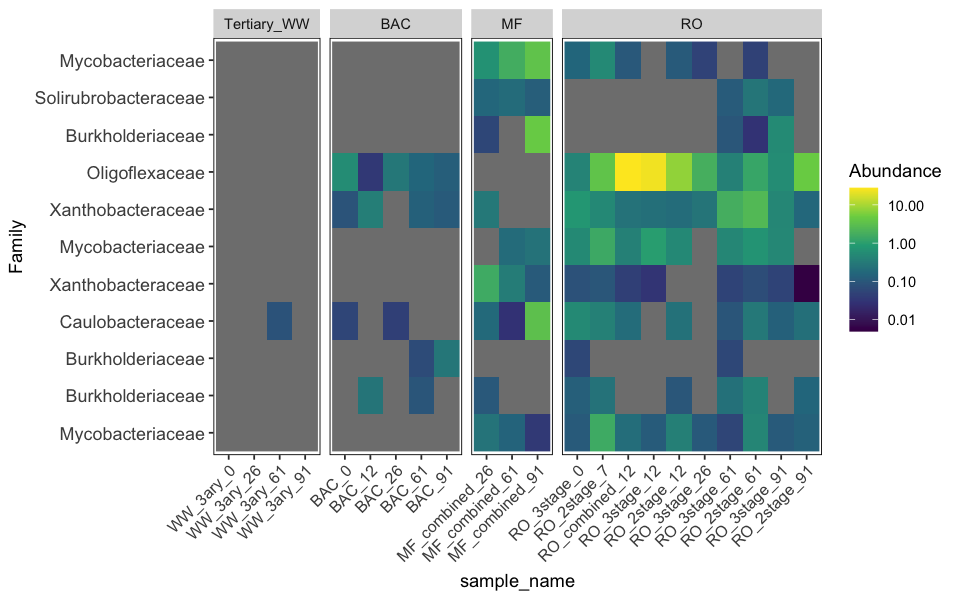

In [123]:
#plot RO shared core taxa
partitions <- get.venn.partitions(cores)
RO_seqs <- partitions[partitions$RO==TRUE & partitions$WW3==TRUE,]$..values..
RO_seqs <- append(RO_seqs, partitions[partitions$RO==TRUE & partitions$BAC==TRUE,]$..values..)
RO_seqs <- append(RO_seqs, partitions[partitions$RO==TRUE & partitions$MF==TRUE,]$..values..)

RO_seqs <- unname(c(unlist(RO_seqs))) #convert to unnamed vector
ps_RO_cross <- prune_taxa(RO_seqs, dataset)

# options(repr.plot.width = 6, repr.plot.height = 4)
# plot_bar(ps_RO_cross, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors) + 
#     theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
#           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
#     facet_grid(.~location_gen, scale="free_x", space="free_x")

options(repr.plot.width = 8, repr.plot.height = 5)
plot_heatmap(ps_RO_cross, taxa.label = "Family", sample.label = "sample_name", sample.order = "sample_date", method=NULL)+
            scale_fill_continuous(type='viridis', trans = log_trans(10))+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")

In [153]:
# #what are these seqs and how abundant are they? Get otu table, tax table, merge, rename

# shared_otus <- as.data.frame(otu_table(ps_RO_cross)) #get otu table
# shared_otus <- as.data.frame(t(shared_otus)) #otus as rows
# shared_taxa <- as.data.frame(tax_table(ps_RO_cross) [, c("Family","Genus")]) #get tax table
# shared_seq_info <- merge(shared_otus, shared_taxa, by=0) #merge otus and tax tables

# shared_seq_info$taxonomy <- paste(shared_seq_info$Family, shared_seq_info$Genus, sep="_") #convert tax to family_genus
# row.names(shared_seq_info) <- shared_seq_info$taxonomy #make tax as rownames
# shared_seq_info <- subset(shared_seq_info, select=c(-Row.names, -Family, -Genus, -taxonomy)) #drop extra columns

# shared_seq_info <- t((shared_seq_info)) #transpose so taxa are columns, samples are rows
# shared_seq_info <- as.data.frame(shared_seq_info)
# names <- subset(sample_data(ps_RO_cross), select=c(Name, filtered_readcounts)) #get sample names for rows
# shared_seq_info <- merge(names, shared_seq_info, by=0)
# row.names(shared_seq_info) <- shared_seq_info$Name
# shared_seq_info <- subset(shared_seq_info, select=c(-Name, -Row.names))
# shared_seq_info <- shared_seq_info[order(row.names(shared_seq_info)),] #sort by sample name

# shared_seq_info


# RO Biofilm samples
Only day 118

Warning message in distfun(comm, method = distance, ...):
“you have empty rows: their dissimilarities may be
                 meaningless in method “bray””
Warning message in metaMDS(veganifyOTU(physeq), distance, ...):
“stress is (nearly) zero: you may have insufficient data”
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”


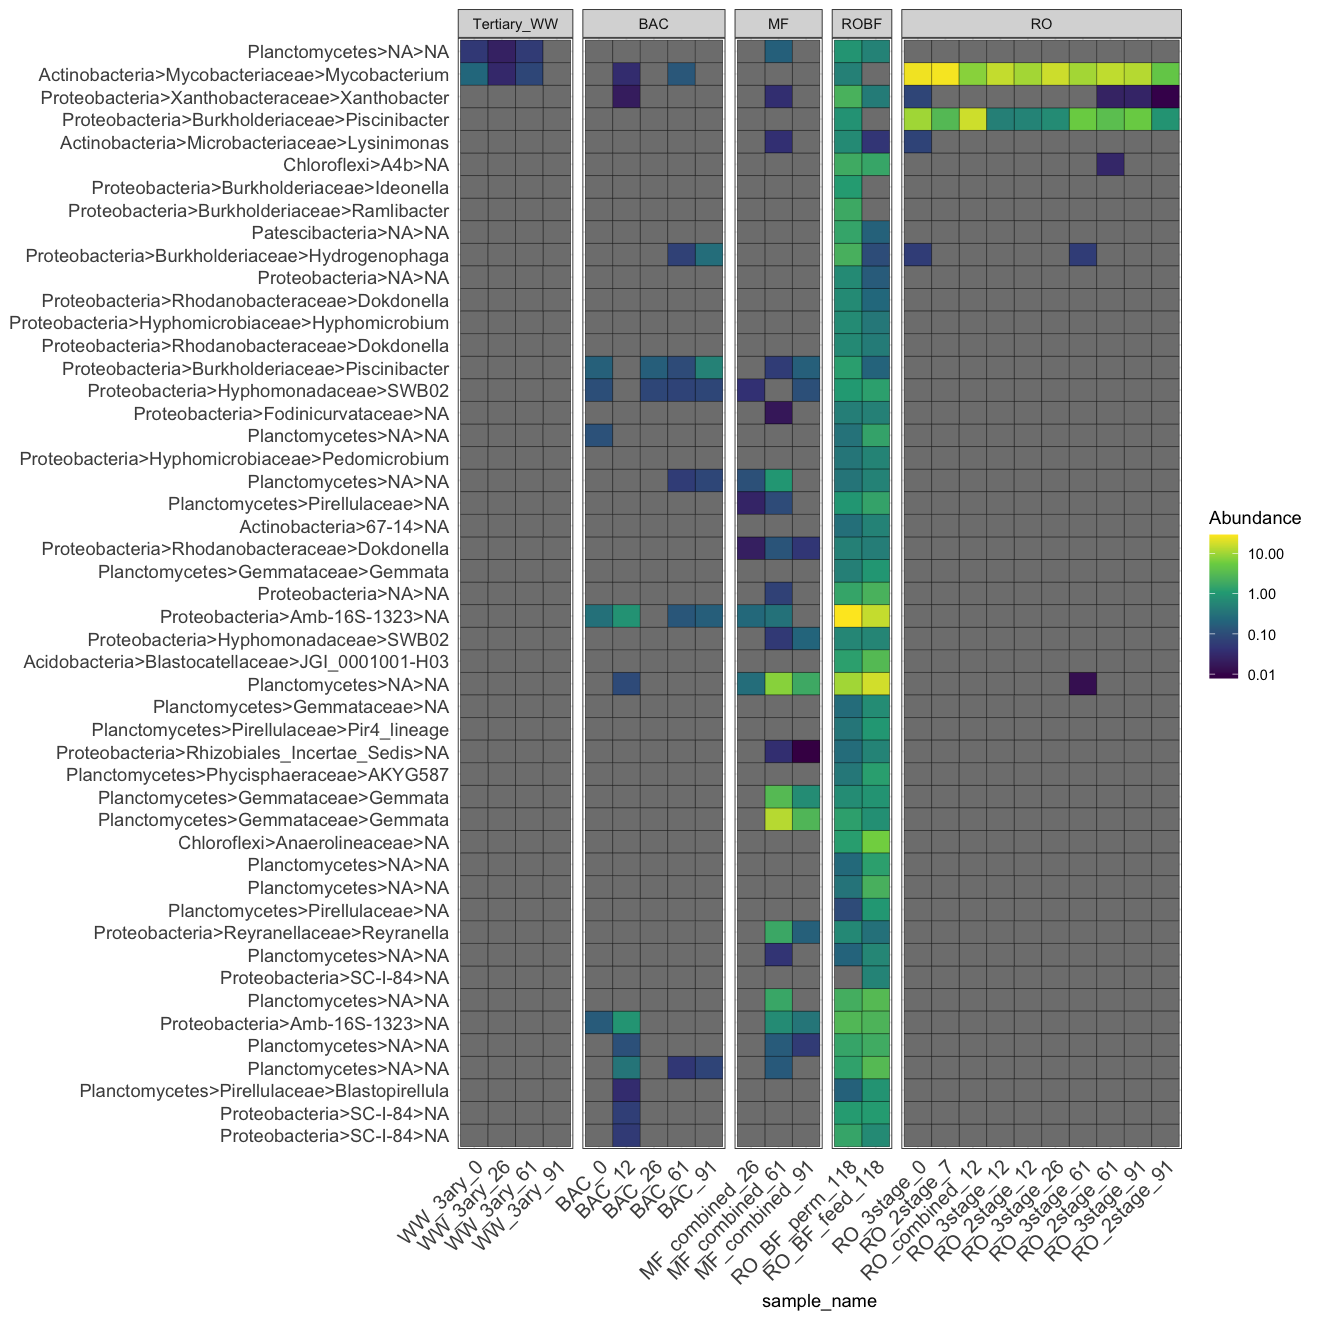

In [36]:
# for day 118, plot heatmap of overlap between MF, RO membrane feed, RO membrane perm, and RO

# plotting just single locations to see more depth
ps_ROmemBF <- subset_samples(ps_dpwf_perc, subset = sample_name %in% c("RO_BF_perm_118", "RO_BF_feed_118"))
ps_ROmemBF_tax <- filter_taxa(ps_ROmemBF, filterfun(kOverA(1, 0.5)), prune=FALSE)
ps_ROmemBF_filt <- prune_taxa(ps_ROmemBF_tax, ps_dpwf_perc)

## optionally, remove the later RO biofilm samples
# ps_ROmemBF_filt <- subset_samples(ps_ROmemBF_filt, !(subset = sample_name %in% c("RO_BF_perm_328", "RO_BF_feed_328")))


#plot heatmap
options(repr.plot.width = 11, repr.plot.height = 11)
plot_heatmap(ps_ROmemBF_filt, taxa.label = "combined", sample.label = "sample_name", sample.order = "sample_date", method="NMDS")+
    scale_fill_continuous(type='viridis', trans = log_trans(10))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")+
    geom_tile(color="black")+
    theme_bw()+
    theme(axis.text.y = element_text(size=11), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12))
     
# ggsave("~/data/awtp2/amplicon_16S/figures/heatmap_ROmemBF_perc_filt1_over0.5.png", device="png", width=11, height=11)